# Introduction to Signals and Systems (examples of periodic waves)

This notebook serves as an introductory way to present signals and systems, using some of music theory. The goal of the notebook is to show students how some of these signals sound. 

Note that initially, the first cell of the notebook provides a look-up table where each of the notes has a given frequency. What does this mean? 

To refresh the memory of some students, we can think about a cosine signal as:

$$
f(t) = \underbrace{\color{blue}{A}}_{\text{\color{blue}{Amplitude}}} \cdot \cos\left(\underbrace{\color{red}{\omega}}_{\text{\color{red}{Frequency (rad/s)}}} t + \underbrace{\color{green}{\phi}}_{\text{\color{green}{Phase}}}\right)
$$

Where:
- $\color{blue}{A}$ = **Amplitude** (maximum value of the signal)
- $\color{red}{\omega}$ = **Frequency** in radians per second (rad/s)
- $\color{green}{\phi}$ = **Phase** (shift in time)

The relationship between frequency in Hz ($f$) and angular frequency ($\omega$) is: 

$$\omega = 2\pi f$$

For example, the note **A4** (concert A) has a frequency of **440 Hz**, which corresponds to an angular frequency of $\omega = 2\pi \times 440 \approx 2764$ rad/s. <span style="color:red">**WARNING: During your exams and assignments, it will be very important to be careful if you're working in either Hertz or radians/second.**</span>

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import os

# Parameters
sampling_rate = 44100  # Hz (CD quality, a little bit higher than 40kHz [we will review this during Nyquist's sampling theorem])
duration = 2.0  # seconds
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Note frequencies (in Hz) - Both for scales and chords
notes = {
    'C': 261.63, 'D': 293.66, 'E': 329.63, 'F': 349.23,
    'G': 392.00, 'A': 440.00, 'B': 493.88,
    'C#': 277.18, 'D#': 311.13, 'F#': 369.99, 'G#': 415.30, 'A#': 466.16,
    'C4': 261.63,  # Middle C (Do)
    'D4': 293.66,  # Re (D)
    'E4': 329.63,  # Mi (E)
    'F4': 349.23,  # Fa (F)
    'G4': 392.00,  # Sol (G)
    'A4': 440.00,  # La (A)
    'B4': 493.88,  # Ti (B)
    'C5': 523.25,  # High C (Do)
}

# Define chord structures (intervals from root in semitones)
chord_types = {
    'major': [0, 4, 7],      # Root, Major 3rd, Perfect 5th
    'minor': [0, 3, 7],      # Root, Minor 3rd, Perfect 5th
    '7': [0, 4, 7, 10],      # Major with minor 7th
    'maj7': [0, 4, 7, 11],   # Major with major 7th
    'add9': [0, 4, 7, 14],   # Major with added 9th
}

The following cell are the auxiliary functions I created to build the notes and chords. 

In [57]:
# =============================================================================
# ALL FUNCTION DEFINITIONS
# =============================================================================

def generate_sine(freq, amplitude=0.5):
    """Generate a sine wave"""
    return amplitude * np.sin(2 * np.pi * freq * t)

def generate_square(freq, amplitude=0.5):
    """Generate a square wave"""
    return amplitude * np.sign(np.sin(2 * np.pi * freq * t))

def generate_sawtooth(freq, amplitude=0.5):
    """Generate a sawtooth wave"""
    return amplitude * 2 * (t * freq - np.floor(t * freq + 0.5))

def get_note_freq(root, semitones_up):
    """Get frequency of a note N semitones above root"""
    return root * (2 ** (semitones_up / 12))

def generate_note(frequency, duration, sample_rate=44100, fade=True):
    """Generate a single note
    
    Parameters:
    -----------
    frequency : float
        Frequency of the note in Hz
    duration : float
        Duration of the note in seconds
    sample_rate : int
        Sampling rate in Hz
    fade : bool
        If True, apply fade in/out envelope to avoid clicks
    """
    t_local = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Generate sine wave
    note_signal = np.sin(2 * np.pi * frequency * t_local)
    
    # Apply envelope (fade in/out to avoid clicks)
    if fade:
        envelope = np.ones_like(t_local)
        fade_samples = int(0.01 * sample_rate)  # 10ms fade
        envelope[:fade_samples] = np.linspace(0, 1, fade_samples)
        envelope[-fade_samples:] = np.linspace(1, 0, fade_samples)
        note_signal = note_signal * envelope
    
    return note_signal

def generate_chord(root_note, chord_type, duration, notes_dict, chord_types_dict, sample_rate=44100, fade=True):
    """Generate a chord with specified root and type
    
    Parameters:
    -----------
    root_note : str
        Root note name (e.g., 'C', 'D', 'F')
    chord_type : str
        Type of chord (e.g., 'major', 'minor', 'maj7')
    duration : float
        Duration of the chord in seconds
    notes_dict : dict
        Dictionary mapping note names to frequencies
    chord_types_dict : dict
        Dictionary mapping chord types to interval lists
    sample_rate : int
        Sampling rate in Hz
    fade : bool
        If True, apply fade in/out envelope to avoid clicks
    """
    t_local = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    root_freq = notes_dict[root_note]
    
    # Generate each note in the chord
    chord_signal = np.zeros_like(t_local)
    intervals = chord_types_dict[chord_type]
    
    for interval in intervals:
        freq = get_note_freq(root_freq, interval)
        chord_signal += np.sin(2 * np.pi * freq * t_local)
    
    # Normalize
    chord_signal = chord_signal / len(intervals)
    
    # Apply envelope (fade in/out to avoid clicks)
    if fade:
        envelope = np.ones_like(t_local)
        fade_samples = int(0.01 * sample_rate)  # 10ms fade
        envelope[:fade_samples] = np.linspace(0, 1, fade_samples)
        envelope[-fade_samples:] = np.linspace(1, 0, fade_samples)
        chord_signal = chord_signal * envelope
    
    return chord_signal

def create_scale(note_list, notes_dict, note_duration=0.5, sample_rate=44100, fade=True):
    """Create a scale from a list of notes
    
    Parameters:
    -----------
    note_list : list
        List of note names to play in sequence
    notes_dict : dict
        Dictionary mapping note names to frequencies
    note_duration : float
        Duration of each note in seconds
    sample_rate : int
        Sampling rate in Hz
    fade : bool
        If True, apply fade in/out envelope to each note
    """
    full_scale = np.array([])
    
    for note_name in note_list:
        freq = notes_dict[note_name]
        note = generate_note(freq, note_duration, sample_rate, fade=fade)
        full_scale = np.concatenate([full_scale, note])
    
    return full_scale

def create_chord_progression(progression, notes_dict, chord_types_dict, chord_duration=2.0, sample_rate=44100, fade=True):
    """Create a sequence of chords
    
    Parameters:
    -----------
    progression : list of tuples
        List of (root_note, chord_type) tuples
    notes_dict : dict
        Dictionary mapping note names to frequencies
    chord_types_dict : dict
        Dictionary mapping chord types to interval lists
    chord_duration : float
        Duration of each chord in seconds
    sample_rate : int
        Sampling rate in Hz
    fade : bool
        If True, apply fade in/out envelope to each chord
    """
    full_song = np.array([])
    
    for root, chord_type in progression:
        chord = generate_chord(root, chord_type, chord_duration, notes_dict, chord_types_dict, sample_rate, fade=fade)
        full_song = np.concatenate([full_song, chord])
    
    return full_song

def save_wav(filename, signal, sample_rate=44100):
    """Save audio signal to WAV file"""
    # Normalize and convert to 16-bit PCM
    signal_normalized = np.int16(signal / np.max(np.abs(signal)) * 32767 * 0.8)
    
    with wave.open(filename, 'w') as wav_file:
        wav_file.setnchannels(1)  # Mono
        wav_file.setsampwidth(2)  # 2 bytes (16-bit)
        wav_file.setframerate(sample_rate)
        wav_file.writeframes(signal_normalized.tobytes())
    
    print(f"Saved: {filename}")

## Example 1: Simple waveforms and visualizations

The typical A note is a waveform at 440 Hz. The remaining of the notes have frequencies also studied and known, which some of them are shown in the look up table in the first cell.

The first example, create three waveforms (sine, square and sawtooth), which we can hear. The sine wave feels "smoother" than the other two waves. 

The second example, create the sum of three notes at the same time. This gives us what is known as a "chord". We can hear and appreciate the generated signal. 

Saved: ./sound_waves/A_sine_wave.wav
Saved: ./sound_waves/c_major.wav
Saved: ./sound_waves/A_square_wave.wav
Saved: ./sound_waves/A_sawtooth_wave.wav


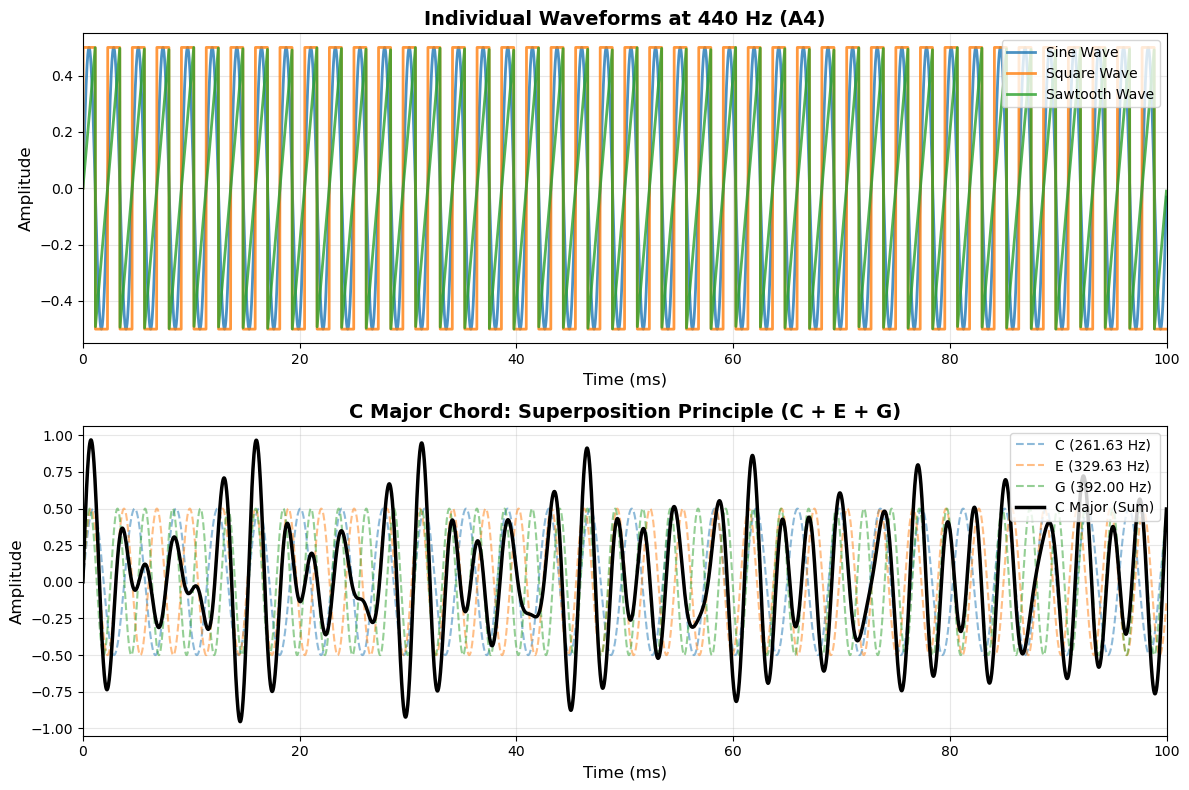

In [73]:
# =============================================================================
# Example 1: Simple waveforms and superpositions (in music theory: chords)
# =============================================================================

# Example 1a: Pure waves (A440 - concert A)
freq_A = 440  # Hz
sine_wave = generate_sine(freq = freq_A)
square_wave = generate_square(freq=freq_A)
sawtooth_wave = generate_sawtooth(freq=freq_A)

# Example 1b: Chord components (C major = C + E + G)
C_note = generate_sine(notes['C4'])  # C
E_note = generate_sine(notes['E4'])  # E
G_note = generate_sine(notes['G4'])  # G

# SUPERPOSITION
C_major = C_note + E_note + G_note
C_major = C_major / np.max(np.abs(C_major))  # Normalize
# Save WAV files
save_dir = './sound_waves/'
os.makedirs(name = save_dir, exist_ok = True)
save_wav(f'{save_dir}A_sine_wave.wav', sine_wave, sampling_rate)
save_wav(f'{save_dir}c_major.wav', C_major, sampling_rate)
save_wav(f'{save_dir}A_square_wave.wav', square_wave, sampling_rate)
save_wav(f'{save_dir}A_sawtooth_wave.wav', sawtooth_wave, sampling_rate)

# Subexample: HOW TO PLOT IN PYTHON
plt.subplots(2, 1, figsize=(12, 8))

# Time vector for plotting (show first 0.01 seconds for clarity)
plot_duration = 0.1  # 100 ms
plot_samples = int(sampling_rate * plot_duration)
t_plot = t[:plot_samples]



# Upper subplot: Individual waveforms (sine, square, sawtooth)
plt.subplot(2, 1, 1)
plt.plot(t_plot * 1000, sine_wave[:plot_samples], label='Sine Wave', linewidth=2, alpha=0.8)
plt.plot(t_plot * 1000, square_wave[:plot_samples], label='Square Wave', linewidth=2, alpha=0.8)
plt.plot(t_plot * 1000, sawtooth_wave[:plot_samples], label='Sawtooth Wave', linewidth=2, alpha=0.8)
plt.title('Individual Waveforms at 440 Hz (A4)', fontsize=14, fontweight='bold')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, plot_duration * 1000])

# Lower subplot: C major chord components and their superposition
plt.subplot(2, 1, 2)
plt.plot(t_plot * 1000, C_note[:plot_samples], label='C (261.63 Hz)', 
         linewidth=1.5, linestyle='--', alpha=0.5)
plt.plot(t_plot * 1000, E_note[:plot_samples], label='E (329.63 Hz)', 
         linewidth=1.5, linestyle='--', alpha=0.5)
plt.plot(t_plot * 1000, G_note[:plot_samples], label='G (392.00 Hz)', 
         linewidth=1.5, linestyle='--', alpha=0.5)
plt.plot(t_plot * 1000, C_major[:plot_samples], label='C Major (Sum)', 
         linewidth=2.5, color='black', alpha=1.0)
plt.title('C Major Chord: Superposition Principle (C + E + G)', fontsize=14, fontweight='bold')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, plot_duration * 1000])

plt.tight_layout()
# plt.savefig(f'{save_dir}waveforms_and_chord.png', dpi=150, bbox_inches='tight')
plt.show()


## Example 2: Increasing the pitch

We can see that when we increase the frecuency, the pitch also increases

Saved: ./sound_waves/c_major_scale.wav


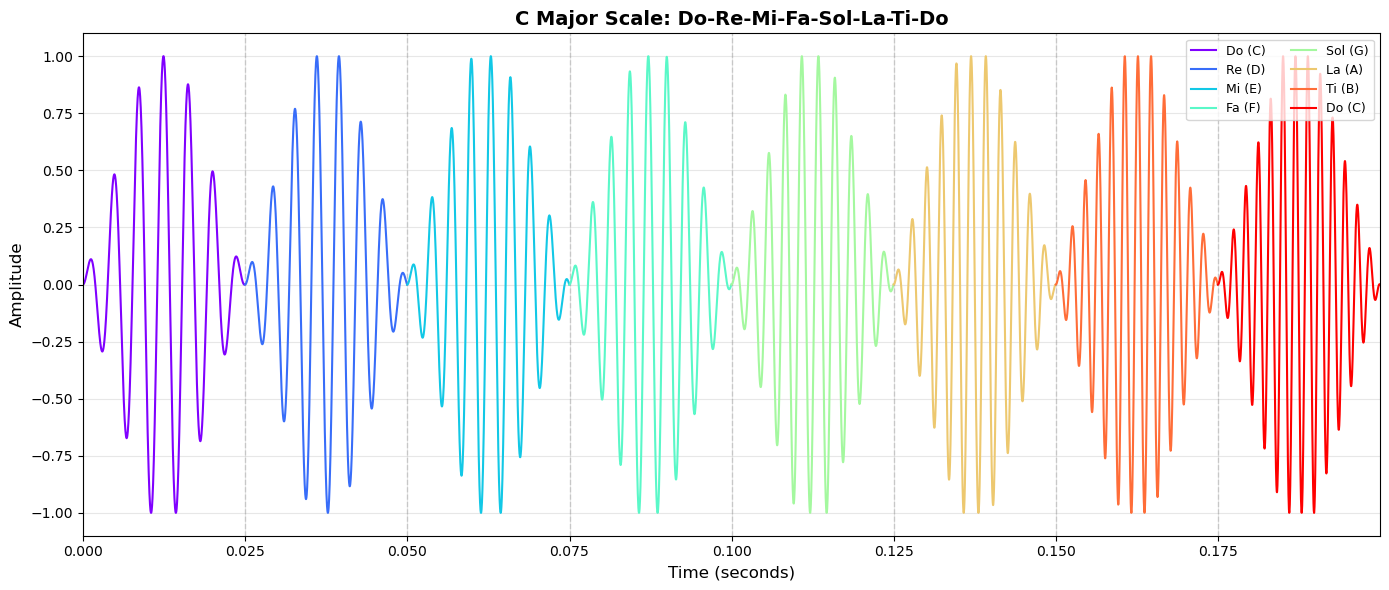

In [85]:
# =============================================================================
# Example 2: C Major Scale (Do-Re-Mi-Fa-Sol-La-Ti-Do)
# =============================================================================

# C Major Scale: Do-Re-Mi-Fa-Sol-La-Ti-Do
scale_notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5']
scale_labels = ['Do (C)', 'Re (D)', 'Mi (E)', 'Fa (F)', 'Sol (G)', 'La (A)', 'Ti (B)', 'Do (C)']

# Generate the scale
sample_rate = 44100
note_duration = .025  # seconds per note (play with this to be able to hear it better or visualize it better)
scale = create_scale(note_list=scale_notes,
                      notes_dict=notes,
                        note_duration=note_duration,
                          sample_rate=sample_rate)

# Save to file
save_wav(f'{save_dir}c_major_scale.wav', scale, sample_rate)

# Plot the scale with different colors for each note
plt.figure(figsize=(14, 6))

# Generate colors for each note
colors = plt.cm.rainbow(np.linspace(0, 1, len(scale_notes)))

# Time vector for the entire scale
t_scale = np.linspace(0, len(scale) / sample_rate, len(scale))

# Calculate samples per note
samples_per_note = int(sample_rate * note_duration)

# Plot each note with its own color
for i, (note_name, label, color) in enumerate(zip(scale_notes, scale_labels, colors)):
    start_idx = i * samples_per_note
    end_idx = (i + 1) * samples_per_note
    
    t_segment = t_scale[start_idx:end_idx]
    signal_segment = scale[start_idx:end_idx]
    
    plt.plot(t_segment, signal_segment, color=color, linewidth=1.5, label=label)
    
    # Add vertical line to mark note transitions
    if i < len(scale_notes) - 1:
        plt.axvline(x=(i + 1) * note_duration, color='gray', linestyle='--', alpha=0.3, linewidth=1)

plt.title('C Major Scale: Do-Re-Mi-Fa-Sol-La-Ti-Do', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend(loc='upper right', fontsize=9, ncol=2)
plt.grid(True, alpha=0.3)
plt.xlim([0, len(scale) / sample_rate])

plt.tight_layout()
# plt.savefig(f'{save_dir}c_major_scale.png', dpi=150, bbox_inches='tight')
plt.show()

NOTE: What do you see that might be special? What happens from one note to the next? 

Answer: We can see that there are, from one note to the other, more peaks (the frequency is higher).

## Example 3: Fun

Simplyfing a lot John Lennon's Imagine, we can recreate the chord projection with the code we have developed. You can hear his original song on [**YouTube**](https://www.youtube.com/watch?v=YkgkThdzX-8). You can see how the different chords are represented in the time and how each one of them has 3 or 4 sine waves summed (look at what I am calling spectrogram).

Saved: ./sound_waves/imagine_progression.wav


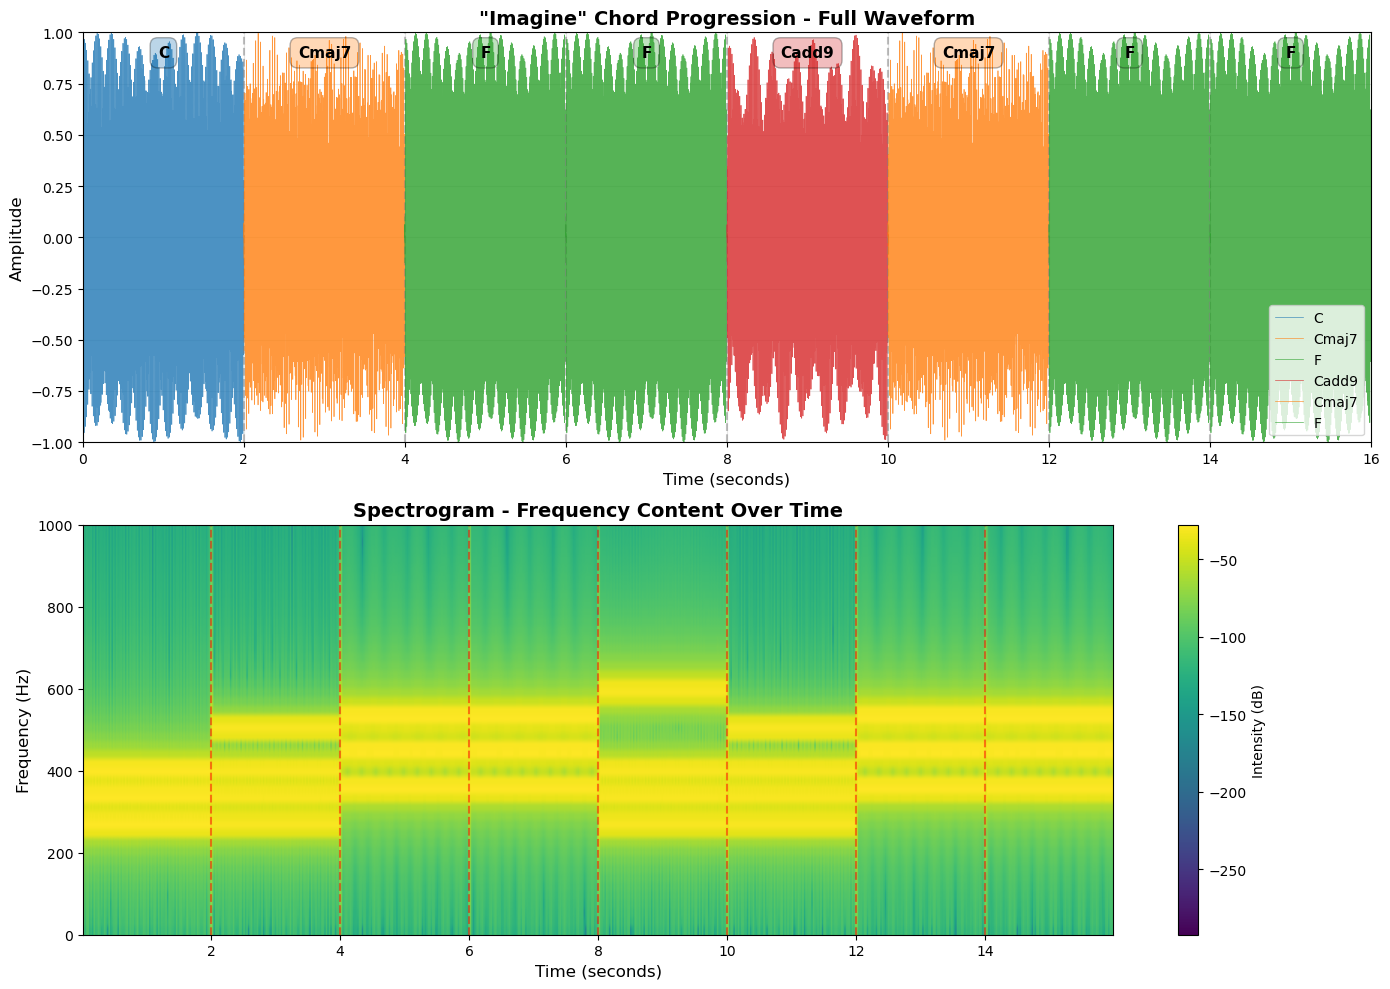

In [88]:
# =============================================================================
# Example 3: "Imagine" Chord Progression (C - Cmaj7 - F)
# =============================================================================

# Actual "Imagine" chord progression: C - Cmaj7 - F - Cadd9 - Cmaj7 - F
progression = [
    ('C', 'major'),
    ('C', 'maj7'),
    ('F', 'major'),
    ('F', 'major'),
    ('C', 'add9'),
    ('C', 'maj7'),
    ('F', 'major'),
    ('F', 'major'),
]

# Generate the progression
sample_rate = 44100
chord_duration = 2 # seconds per chord
song = create_chord_progression(progression,
                                notes,
                                chord_types,
                                chord_duration,
                                sample_rate)

# Save to file
save_wav(f'{save_dir}imagine_progression.wav', song, sample_rate)

# Create figure with 2 rows, 1 column
plt.figure(figsize=(14, 10))

# Time vector for the entire song
t_song = np.linspace(0, len(song) / sample_rate, len(song))

# Calculate samples per chord
samples_per_chord = int(sample_rate * chord_duration)

# Color map for different chord types
chord_labels = ['C', 'Cmaj7', 'F', 'F', 'Cadd9', 'Cmaj7', 'F', 'F']
chord_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#2ca02c', '#d62728', '#ff7f0e', '#2ca02c', '#2ca02c']

# Upper subplot: Full waveform with color-coded chords
plt.subplot(2, 1, 1)
for i, (label, color) in enumerate(zip(chord_labels, chord_colors)):
    start_idx = i * samples_per_chord
    end_idx = (i + 1) * samples_per_chord
    
    t_segment = t_song[start_idx:end_idx]
    signal_segment = song[start_idx:end_idx]
    
    # Only add label once per unique chord
    if i == 0 or label != chord_labels[i-1]:
        plt.plot(t_segment, signal_segment, color=color, linewidth=0.5, alpha=0.8, label=label)
    else:
        plt.plot(t_segment, signal_segment, color=color, linewidth=0.5, alpha=0.8)
    
    # Add vertical line to mark chord transitions
    if i < len(progression) - 1:
        plt.axvline(x=(i + 1) * chord_duration, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
    
    # Add chord label at the top
    plt.text(i * chord_duration + chord_duration/2, 0.9, label, 
             ha='center', va='center', fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.3))

plt.title('"Imagine" Chord Progression - Full Waveform', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, len(song) / sample_rate])
plt.ylim([-1, 1])

# Lower subplot: Spectrogram showing frequency content over time
plt.subplot(2, 1, 2)
spec_plot = plt.specgram(song, Fs=sample_rate, cmap='viridis', NFFT=2048, noverlap=1024)
plt.title('Spectrogram - Frequency Content Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Frequency (Hz)', fontsize=12)
plt.ylim([0, 1000])  # Focus on relevant frequency range

# Add chord labels and separators to spectrogram
for i, label in enumerate(chord_labels):
    if i < len(progression) - 1:
        plt.axvline(x=(i + 1) * chord_duration, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

# Add colorbar
plt.colorbar(label='Intensity (dB)')

plt.tight_layout()
# plt.savefig(f'{save_dir}imagine_progression.png', dpi=150, bbox_inches='tight')
plt.show()

# Conclusion

During this semester, the student will gain the ability to analyze both continuous and discrete signals, and implement techniques to transform them. 